# 0. Imports & Functions

In [806]:
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold, GroupKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.distributed
import pandas as pd
import numpy as np
from ABRA_35 import interpolate_and_smooth, CNN, plot_wave, calculate_and_plot_wave, plot_waves_single_frequency, arfread, get_str, calculate_hearing_threshold, all_thresholds, peak_finding
import warnings
from sklearn.preprocessing import StandardScaler,MinMaxScaler
warnings.filterwarnings('ignore')
import os
import io
import re
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GroupShuffleSplit
import os
import struct
import datetime
# from skfda import FDataGrid
# from skfda.preprocessing.dim_reduction import FPCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import pandas as pd
import struct
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import gaussian_filter1d
import torch.nn as nn
import splitfolders
from tensorflow.keras.models import load_model
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import torch
from PIL import Image
from torchvision.transforms import ToTensor
import random
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
# import pytorch libraries
%matplotlib inline
import torch 
import torch.autograd as autograd 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np4
from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score

import skfda
from skfda.ml.regression import LinearRegression
from skfda.representation.basis import BSplineBasis, FourierBasis, FDataBasis
from skfda.representation import FDataGrid
from skfda.preprocessing.smoothing import BasisSmoother
# from skfda.regression.linear_model import LinearFunctionalRegressor is no longer available? :(



In [725]:
filter1 = 128
filter2 = 32
dropout1 = 0.5
dropout2 = 0.3
dropout_fc = 0.1

# Model initialization
peak_finding_model = CNN(filter1, filter2, dropout1, dropout2, dropout_fc)
model_loader = torch.load('./models/waveI_cnn.pth')
peak_finding_model.load_state_dict(model_loader)
peak_finding_model.eval()

CNN(
  (conv1): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=1952, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout_fc): Dropout(p=0.1, inplace=False)
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [726]:
def peak_finding(wave):
    # Prepare waveform
    waveform=interpolate_and_smooth(wave) # Added indexing per calculate and plot wave function
    # waveform_torch = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0) archived ABRA
    waveform_torch = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0).unsqueeze(0) #newer ABRA
    # print(waveform_torch)
    # Get prediction from model
    outputs = peak_finding_model(waveform_torch)
    prediction = int(round(outputs.detach().numpy()[0][0], 0))
    # prediction_test = int(round(outputs.detach().numpy()[0], 0))
    # print("Model output:", outputs, "Prediction true start:", prediction)

    # Apply Gaussian smoothing
    smoothed_waveform = gaussian_filter1d(waveform, sigma=1)

    # Find peaks and troughs
    n = 18
    t = 14
    # start_point = prediction - 9 archived ABRA
    start_point = prediction - 6 #newer ABRA
    smoothed_peaks, _ = find_peaks(smoothed_waveform[start_point:], distance=n)
    smoothed_troughs, _ = find_peaks(-smoothed_waveform, distance=t)
    sorted_indices = np.argsort(smoothed_waveform[smoothed_peaks+start_point])
    highest_smoothed_peaks = np.sort(smoothed_peaks[sorted_indices[-5:]] + start_point)
    relevant_troughs = np.array([])
    for p in range(len(highest_smoothed_peaks)):
        c = 0
        for t in smoothed_troughs:
            if t > highest_smoothed_peaks[p]:
                if p != 4:
                    try:
                        if t < highest_smoothed_peaks[p+1]:
                            relevant_troughs = np.append(relevant_troughs, int(t))
                            break
                    except IndexError:
                        pass
                else:
                    relevant_troughs = np.append(relevant_troughs, int(t))
                    break
    relevant_troughs = relevant_troughs.astype('i')
    return highest_smoothed_peaks, relevant_troughs

def extract_metadata(metadata_lines):
    # Dictionary to store extracted metadata
    metadata = {}
    
    for line in metadata_lines:
        # Extract SW FREQ
        freq_match = re.search(r'SW FREQ:\s*(\d+\.?\d*)', line)
        if freq_match:
            metadata['SW_FREQ'] = float(freq_match.group(1))
        
        # Extract LEVELS
        levels_match = re.search(r':LEVELS:\s*([^:]+)', line)
        if levels_match:
            # Split levels and convert to list of floats
            metadata['LEVELS'] = [float(level) for level in levels_match.group(1).split(';') if level]
    
    return metadata

def read_custom_tsv(file_path):
    # Read the entire file
    with open(file_path, 'r', encoding='ISO-8859-1') as f:
        content = f.read()
    
    # Split the content into metadata and data sections
    metadata_lines = []
    data_section = None
    
    # Find the ':DATA' marker
    data_start = content.find(':DATA')
    
    if data_start != -1:
        # Extract metadata (lines before ':DATA')
        metadata_lines = content[:data_start].split('\n')
        
        # Extract data section
        data_section = content[data_start:].split(':DATA')[1].strip()
    
    # Extract specific metadata
    metadata = extract_metadata(metadata_lines)
    
    # Read the data section directly
    try:
        # Use StringIO to create a file-like object from the data section
        raw_data = pd.read_csv(
            io.StringIO(data_section), 
            sep='\s+',  # Use whitespace as separator
            header=None
        )
        raw_data = raw_data.T
        # Add metadata columns to the DataFrame
        if 'SW_FREQ' in metadata:
            raw_data['Freq(kHz)'] = metadata['SW_FREQ']
            # raw_data['Freq(Hz)'] = raw_data['Freq(Hz)'].apply(lambda x: x*1000)
        
        if 'LEVELS' in metadata:
            # Repeat levels to match the number of rows
            levels_repeated = metadata['LEVELS'] * (len(raw_data) // len(metadata['LEVELS']) + 1)
            raw_data['Level(dB)'] = levels_repeated[:len(raw_data)]
        
        filtered_data = raw_data.apply(pd.to_numeric, errors='coerce').dropna()
        filtered_data.columns = filtered_data.columns.map(str)

        columns = ['Freq(kHz)'] + ['Level(dB)'] + [col for col in filtered_data.columns if col.isnumeric() == True]
        filtered_data = filtered_data[columns]
        return filtered_data
    
    except Exception as e:
        print(f"Error reading data: {e}")
        return None, metadata

In [727]:
def peaks_troughs_amp_final(df, freq, db, time_scale=10, multiply_y_factor=1.0, units='Microvolts'):
    db_column = 'Level(dB)'
    
    khz = df[(df['Freq(kHz)'] == freq) & (df[db_column] == db)]
    if not khz.empty:
        index = khz.index.values[0]
        final = df.loc[index, '0':].dropna()
        final = pd.to_numeric(final, errors='coerce').dropna()

        target = int(244 * (time_scale / 10))
        
        # Process the wave as in calculate_and_plot_wave
        y_values = interpolate_and_smooth(final, target)
        
        # Apply scaling factor
        y_values *= multiply_y_factor
        
        # Handle units conversion if needed
        if units == 'Nanovolts':
            y_values /= 1000
            
        # Generate normalized version for peak finding
        y_values_fpf = interpolate_and_smooth(y_values[:244])
        
        # Standardize and normalize for peak finding, exactly as in the original
        flattened_data = y_values_fpf.flatten().reshape(-1, 1)
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(flattened_data)
        min_max_scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = min_max_scaler.fit_transform(standardized_data).reshape(y_values_fpf.shape)
        y_values_fpf = interpolate_and_smooth(scaled_data[:244])
        
        # Find peaks using the normalized data
        highest_peaks, relevant_troughs = peak_finding(y_values_fpf)
        
        # Calculate amplitude on the processed but non-normalized data
        if highest_peaks.size > 0 and relevant_troughs.size > 0:
            # Following the same approach as in the display_metrics_table function
            first_peak_amplitude = y_values[highest_peaks[0]] - y_values[relevant_troughs[0]]
            return highest_peaks, y_values, first_peak_amplitude
    
    return None, None, None

In [728]:
def full_interpolation(df, freq, db, time_scale=10, multiply_y_factor=1.0, units='Microvolts'):
    
    khz = df[(df['Freq(kHz)'] == freq) & (df['Level(dB)'] == db)]
    # print(khz)
    if not khz.empty:
        index = khz.index.values[0]
        final = df.loc[index, '0':].dropna()
        final = pd.to_numeric(final, errors='coerce').dropna()

        target = int(244 * (time_scale / 10))
        
        # Process the wave as in calculate_and_plot_wave
        y_values = interpolate_and_smooth(final, target)

        # print(f"Interpolated y_values: {y_values[:5]}")
        # print(f"Any NaNs? {np.isnan(y_values).any()}")

        if final.empty:
            print(f"Warning: Empty waveform for {freq}kHz @ {db}dB")
            return np.full((1, 244), np.nan)
        
        # Apply scaling factor
        y_values *= multiply_y_factor
        
        # Handle units conversion if needed
        if units == 'Nanovolts':
            y_values /= 1000
            
        # Generate normalized version for peak finding
        y_values_fpf = interpolate_and_smooth(y_values[:244])
        
        # Standardize and normalize for peak finding, exactly as in the original
        flattened_data = y_values_fpf.flatten().reshape(-1, 1)
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(flattened_data)
        min_max_scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = min_max_scaler.fit_transform(standardized_data).reshape(y_values_fpf.shape)
    
        return scaled_data

Latency detection model to parametrize functional model based on individual wave morphology

In [729]:
def latency_all_peaks(highest_peaks, y_values, time_scale):
    latencies = []
    num_peaks = highest_peaks.size
    if num_peaks > 0:  # Check if highest_peaks is not empty
        for n in range(num_peaks): # SHOULD be 5 but there are cases where there are less. Will handle in later loops
            lat = highest_peaks[n] * (time_scale / len(y_values)) # Based on ABRA logic
            latencies.append(lat)
        return latencies
    else:
        print("No peaks detected. Check input data")
        return None

# 1. Data Imports

In [730]:
# del int
time_scale = 18
amp_per_freq = {'Subject': [], 'Latencies' : [], 'Freq(kHz) (x1)': [], 'Level(dB) (x2)': [], 'Amplitude (x3)':[]}
start_path = '/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/abr_data/WPZ Electrophysiology'
for subject in os.listdir(start_path):
    # print("Subject:",subject)
    for fq in os.listdir(os.path.join(start_path,subject)):
        # print(fq)
        if fq.startswith('ABR') and fq.endswith('.tsv'):
            path = os.path.join(start_path,subject,fq)
            data_df = read_custom_tsv(path)
            # print(data_df)
            freqs = data_df['Freq(kHz)'].unique().tolist()
            levels = data_df['Level(dB)'].unique().tolist()
            for freq in freqs:
                for lvl in levels:
                    highest_peaks, y_values, amp = peaks_troughs_amp_final(df=data_df, freq=freq, db=lvl, time_scale=time_scale)
                    latencies = latency_all_peaks(highest_peaks, y_values, time_scale)
                    if len(latencies) < 5:
                        print(subject, freq , latencies)
                        continue
                    amp_per_freq['Subject'].append(subject)
                    amp_per_freq['Freq(kHz) (x1)'].append(freq)
                    amp_per_freq['Level(dB) (x2)'].append(lvl)
                    amp_per_freq['Amplitude (x3)'].append(amp)
                    amp_per_freq['Latencies'].append(latencies)
        else:
            pass


amp_df_full = pd.DataFrame(data=amp_per_freq)

raw_synapse_counts = pd.read_excel('/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/WPZ Ribbon and Synapse Counts.xlsx')
# raw_synapse_counts = raw_synapse_counts.mask(lambda x: x.isnull()).dropna() # old approach 
raw_synapse_counts = raw_synapse_counts.mask(lambda x: x.isna(),0)
raw_synapse_counts['Synapses to IHC (y1)'] = raw_synapse_counts.iloc[:,6]
raw_synapse_counts['vx (x4)'] = raw_synapse_counts['vx']
raw_synapse_counts.drop(columns=['vx'], inplace=True)
raw_synapse_counts.rename(columns={'Freq':'Freq(kHz) (x1)'}, inplace=True)
raw_synapse_counts.rename(columns={'Case':'Subject'}, inplace=True)

WPZ62 45.2 [np.float64(3.3211845102505695), np.float64(5.207289293849659), np.float64(7.585421412300684), np.float64(9.225512528473804)]


In [731]:
# raw_synapse_counts[raw_synapse_counts['Subject'] == 'WPZ157']
lens = [len(x) for x in amp_df_full['Latencies']]
np.unique(lens)

array([5])

In [732]:
# Version 1 - values per vx

paired = amp_df_full.join(raw_synapse_counts.set_index(['Subject', 'Freq(kHz) (x1)']), on=['Subject', 'Freq(kHz) (x1)'])
# slice = paired[paired['Subject']=='WPZ174'][['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'IHCs (y2)']]
final = paired[['Subject', 'Latencies', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'IHCs']]
final_clean = final.dropna()

# adding in the strain feature
strains = pd.read_excel('/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/WPZ Mouse groups.xlsx')
final_clean_strained = final_clean.join(strains.set_index('ID#'), on='Subject')
final_clean_strained['Strain'] = final_clean_strained['Strain'].str.strip()
final_clean_strained = final_clean_strained.rename(columns={'Strain': 'Strain (x5)'})
final_clean_strained = final_clean_strained.dropna()
final_clean_strained = final_clean_strained[['Subject', 'Latencies', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Synapses to IHC (y1)', 'Group']]

final_clean_strained_grouped = final_clean_strained.copy()
final_clean_strained_grouped['Group - dB'] = final_clean_strained_grouped['Group'].apply(lambda x: x.split(' ')[0] if x.split(' ')[0].endswith('dB') else 'Control')
final_clean_strained_grouped['Group - Time Elapsed'] = final_clean_strained_grouped['Group'].apply(lambda x: x.split(' ')[1] if x.split(' ')[1].endswith(('h', 'wks', 'w')) else x.split(' ')[0])
final_clean_strained_grouped.head()

final_clean_strained_grouped_pos = final_clean_strained_grouped.copy()
final_clean_strained_grouped_pos['Amplitude (x3)'] = final_clean_strained_grouped['Amplitude (x3)'].apply(lambda x: 0 if x < 0 else x)

final_clean_strained_grouped_pos_cleangroup = final_clean_strained_grouped_pos.copy()
final_clean_strained_grouped_pos_cleangroup['Group'] = final_clean_strained_grouped_pos_cleangroup['Group'].apply(lambda x: x.strip())

final_clean_strained_grouped_pos_cleangroup.head()
final_clean_strained_grouped_pos_cleangroup_vs = final_clean_strained_grouped_pos_cleangroup.copy()
final_clean_strained_grouped_pos_cleangroup_vs['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs['Group - dB']
# final_clean_strained_grouped_pos_cleangroup_vs['Group - Time Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs['Group - Time Elapsed']
final_clean_strained_grouped_pos_cleangroup_vs = final_clean_strained_grouped_pos_cleangroup_vs[['Subject','Latencies', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)',
       'vx (x4)', 'Strain (x5)','Group - dB (x6)', 'Group - Time Elapsed', 'Group','Synapses to IHC (y1)']]

def split_on_number(input_string):
    return re.findall(r"[A-Za-z]+|\d+", input_string)

hrs_week = 24*7

final_clean_strained_grouped_pos_cleangroup_vs_timed = final_clean_strained_grouped_pos_cleangroup_vs.copy()
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(lambda x: '0dB' if x == 'Control' else x)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(split_on_number)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(lambda x: x[0])
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(lambda x: int(x.strip()))
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Split'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed'].apply(split_on_number)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Magn.'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Split'].apply(lambda x: x[0])
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Magn.'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Magn.'].apply(lambda x: int(x.strip()))
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Unit'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Split'].apply(lambda x: x[1])
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Unit'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Unit'].apply(lambda x: "wks" if x == 'w' else x)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Hours Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed.apply(lambda row: row['Group - Time Elapsed - Magn.']* hrs_week if row['Group - Time Elapsed - Unit'] == 'wks' else row['Group - Time Elapsed - Magn.'], axis = 1)

In [733]:
# Version 2 - Averaged per Vx

paired2 = amp_df_full.join(raw_synapse_counts.set_index(['Subject', 'Freq(kHz) (x1)']), on=['Subject', 'Freq(kHz) (x1)'])
# lilslice = paired[paired['Subject']=='WPZ174'][['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'IHCs']]
final2 = paired2[['Subject', 'Latencies', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'Synapses', 'IHCs']]
final_clean2 = final2.dropna()

# adding in the strain feature
strains = pd.read_excel('/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/WPZ Mouse groups.xlsx')
final_clean_strained2 = final_clean2.join(strains.set_index('ID#'), on='Subject')
final_clean_strained2['Strain'] = final_clean_strained2['Strain'].str.strip()
final_clean_strained2 = final_clean_strained2.rename(columns={'Strain': 'Strain (x5)'})
final_clean_strained2 = final_clean_strained2.dropna()
final_clean_strained2 = final_clean_strained2[['Subject', 'Latencies', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Synapses to IHC (y1)', 'Group', 'Synapses', 'IHCs']]
# np.unique(final_clean_strained2['Group'])

# final_clean_70 = final_clean[final_clean['Level(dB) (x2)'] >= 70.0]
# final_clean_strained_70 = final_clean_strained[final_clean_strained['Level(dB) (x2)'] >= 70.0]
# # np.unique(final_clean['Level(dB) (x2)']) max level is 80 db
# len(final_clean), len(final_clean_70) # 10000 less data points!!!

final_clean_strained_grouped2 = final_clean_strained2.copy()
final_clean_strained_grouped2['Group - dB'] = final_clean_strained_grouped2['Group'].apply(lambda x: x.split(' ')[0] if x.split(' ')[0].endswith('dB') else 'Control')
final_clean_strained_grouped2['Group - Time Elapsed'] = final_clean_strained_grouped2['Group'].apply(lambda x: x.split(' ')[1] if x.split(' ')[1].endswith(('h', 'wks', 'w')) else x.split(' ')[0])
final_clean_strained_grouped2.head()

final_clean_strained_grouped_pos2 = final_clean_strained_grouped2.copy()
final_clean_strained_grouped_pos2['Amplitude (x3)'] = final_clean_strained_grouped2['Amplitude (x3)'].apply(lambda x: 0 if x < 0 else x)

len(final_clean_strained_grouped_pos2[final_clean_strained_grouped_pos2['Amplitude (x3)'] < 0])

final_clean_strained_grouped_pos2['Amplitude (x3)'] = final_clean_strained_grouped2['Amplitude (x3)'].apply(lambda x: 0 if x < 0 else x)

# final_clean_strained_grouped_pos[(final_clean_strained_grouped_pos['Subject'] == 'WPZ66') & (final_clean_strained_grouped_pos['Amplitude (x3)'] ==0.055901451434921576)
final_clean_strained_grouped_pos_cleangroup2 = final_clean_strained_grouped_pos2.copy()
final_clean_strained_grouped_pos_cleangroup2['Group'] = final_clean_strained_grouped_pos_cleangroup2['Group'].apply(lambda x: x.strip())
np.unique(final_clean_strained_grouped_pos_cleangroup2['Group'])

final_clean_strained_grouped_pos_cleangroup2.head()
final_clean_strained_grouped_pos_cleangroup_vs2 = final_clean_strained_grouped_pos_cleangroup2.copy()
final_clean_strained_grouped_pos_cleangroup_vs2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs2['Group - dB']
# final_clean_strained_grouped_pos_cleangroup_vs['Group - Time Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs['Group - Time Elapsed']
final_clean_strained_grouped_pos_cleangroup_vs2 = final_clean_strained_grouped_pos_cleangroup_vs2[['Subject',  'Latencies', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)',
       'vx (x4)', 'Strain (x5)','Group - dB (x6)', 'Group - Time Elapsed', 'Group','Synapses to IHC (y1)', 'Synapses', 'IHCs']]

def split_on_number(input_string):
    return re.findall(r"[A-Za-z]+|\d+", input_string)

hrs_week = 24*7

final_clean_strained_grouped_pos_cleangroup_vs_timed2 = final_clean_strained_grouped_pos_cleangroup_vs2.copy()
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'].apply(lambda x: '0dB' if x == 'Control' else x)
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'].apply(split_on_number)
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'].apply(lambda x: x[0])
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'].apply(lambda x: int(x.strip()))
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Split'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed'].apply(split_on_number)
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Magn.'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Split'].apply(lambda x: x[0])
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Magn.'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Magn.'].apply(lambda x: int(x.strip()))
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Unit'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Split'].apply(lambda x: x[1])
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Unit'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Unit'].apply(lambda x: "wks" if x == 'w' else x)
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Hours Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2.apply(lambda row: row['Group - Time Elapsed - Magn.']* hrs_week if row['Group - Time Elapsed - Unit'] == 'wks' else row['Group - Time Elapsed - Magn.'], axis = 1)
final_clean_strained_grouped_pos_cleangroup_vs_timed2

freqs = np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2['Freq(kHz) (x1)'])
subs = np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2['Subject'])
final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx = final_clean_strained_grouped_pos_cleangroup_vs_timed2.copy()
for freq in freqs:
    for sub in subs:
        mask = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub)] # global for updates
        if len(mask) > 0:

            mask1 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['vx (x4)'] == 'v1')]
            mask2 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['vx (x4)'] == 'v2')]

            if not mask1.empty and not mask2.empty:
                mask1 = mask1.reset_index().iloc[0,:]
                mask2 = mask2.reset_index().iloc[0,:]

                total_syns = float(mask1['Synapses'] + mask2['Synapses'])
                total_ihcs = float(mask1['IHCs'] + mask2['IHCs'])

                if total_ihcs != 0:
                    ratio = total_syns / total_ihcs

                # if total_ihcs == 0 or total_syns == 0:
                #     print(sub, freq, total_syns, total_ihcs)
                # if total_syns == 0.0 or total_ihcs == 0.0:
                #     print(sub, freq)
                mask_index = mask.index
                final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[mask_index,'Synapse to IHC Ratio per Freq (y2)'] = ratio

In [892]:
np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Strain (x5)'])

array(['C57B6', 'CBA/CaJ'], dtype=object)

In [902]:
final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx_encoded = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.copy()
final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx_encoded['Strain encoded (x5)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx_encoded['Strain (x5)'].apply(lambda x: 0 if x=='C57B6' else 1)
final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx_encoded.head()


,Subject,Latencies,Freq(kHz) (x1),Level(dB) (x2),Amplitude (x3),vx (x4),Strain (x5),Group - dB (x6),Group - Time Elapsed,Group,Synapses to IHC (y1),Synapses,IHCs,Group - Time Elapsed - Split,Group - Time Elapsed - Magn.,Group - Time Elapsed - Unit,Group - Hours Elapsed (x7),Synapse to IHC Ratio per Freq (y2),Strain encoded (x5)
0,WPZ145,"[3.0751708428246016, 5.371298405466971, 6.6013...",45.2,70.0,0.033579,v1,C57B6,98,8wks,98dB 8wks post,8.750000,77.0,8.8,"[8, wks]",8,wks,1344,9.831461,0
0,WPZ145,"[3.0751708428246016, 5.371298405466971, 6.6013...",45.2,70.0,0.033579,v2,C57B6,98,8wks,98dB 8wks post,10.888889,98.0,9,"[8, wks]",8,wks,1344,9.831461,0
1,WPZ145,"[3.0341685649202734, 4.018223234624146, 5.9863...",45.2,75.0,0.034262,v1,C57B6,98,8wks,98dB 8wks post,8.750000,77.0,8.8,"[8, wks]",8,wks,1344,9.831461,0
1,WPZ145,"[3.0341685649202734, 4.018223234624146, 5.9863...",45.2,75.0,0.034262,v2,C57B6,98,8wks,98dB 8wks post,10.888889,98.0,9,"[8, wks]",8,wks,1344,9.831461,0
2,WPZ145,"[2.296127562642369, 3.6492027334851938, 6.5193...",45.2,80.0,0.154224,v1,C57B6,98,8wks,98dB 8wks post,8.750000,77.0,8.8,"[8, wks]",8,wks,1344,9.831461,0


# 2. Waves as Inputs (FLM) - no additional predictors

## a) Extract data as waves from ABR

In [734]:
time_scale = 18
start_path = '/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/abr_data/WPZ Electrophysiology'
subject_ABRs = {}

for subject in os.listdir(start_path):
    for fq in os.listdir(os.path.join(start_path,subject)):
        if fq.startswith('ABR') and fq.endswith('.tsv'):
            match = re.search(r'-L-([\d.]+)\.tsv$', fq)
            if match:
                freq = float(match.group(1))
                # if freq == 6.0 or freq == 7.0:
                #     print(subject, freq)
                # freqs.add(freq)
                path = os.path.join(start_path,subject,fq)
                data_df = read_custom_tsv(path)
                if data_df['Freq(kHz)'].iloc[0] == freq:
                    subject_ABRs[(subject, freq)] = data_df
                else:
                    print(f"Skipping subject {subject}, frequency {freq} due to mismatch.")

Skipping subject WPZ144, frequency 45.2 due to mismatch.
Skipping subject WPZ161, frequency 45.2 due to mismatch.
Skipping subject WPZ156, frequency 45.2 due to mismatch.
Skipping subject WPZ146, frequency 45.2 due to mismatch.
Skipping subject WPZ178, frequency 11.3 due to mismatch.
Skipping subject WPZ40, frequency 45.2 due to mismatch.
Skipping subject WPZ98, frequency 45.2 due to mismatch.
Skipping subject WPZ155, frequency 8.0 due to mismatch.


## b) Transform using skfda.DataGrid

In [735]:
time_scale = 18
subjects = []
frequencies = []
levels = []
waves = []
ys = []
fails = []

for (sub, freq), df in subject_ABRs.items():
    for lvl in np.unique(subject_ABRs[(sub, freq)]['Level(dB)']):
        lvl = float(lvl)
        wave = full_interpolation(df, freq, lvl, time_scale)
        wave = np.asarray(wave, dtype=float)
        # if wave.size != 244:
        #     fails.append((sub, freq, lvl))
        # else:
        wave_input = skfda.FDataGrid(
            data_matrix=wave,
            grid_points=time_scale * np.arange(0, 244) / 244
        )
        y = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub)\
            & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq)\
            & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Level(dB) (x2)'] == lvl)]\
            ['Synapse to IHC Ratio per Freq (y2)']
        
        if len(y) > 0:
            y = float(y.iloc[0])

        # print((sub, freq, lvl, y))
        subjects.append(sub)
        frequencies.append(freq)
        levels.append(lvl)
        waves.append(wave_input)
        ys.append(y)

In [736]:
fail_subs = set()
for fail in fails:
    # print(fail[0])
    fail_subs.add(fail[1])
# fail_subs
len(fails)

0

## c) Create and fit data to new bases

Creating a new basis is key for a functional regression. It brings the various waveforms into lower dimensional space by isolating the signal and filtering out noise. Basis-spline or B-spline is particularly useful for ABR waveforms:
- Piecewise function = can control amount of smoothing and coefficient weighting *locally* (great for analyzing distinct peaks/troughs)
    - We should use 5 knots or "pieces", 1 knot for each wave. 
- Does not assume periodicity like Fourier basis, giving a more natural fit
- Cubic spline is standard for waveform data to capture wave variability without overly smoothing
    - zB: 5 knots and 3 degrees (cubic splining) -> 7 basis pieces (5 + 3 -1) AKA we are splitting each waveform into 7 independent blocks

https://projecteuclid.org/journals/annals-of-statistics/volume-33/issue-6/Functional-linear-regression-analysis-for-longitudinal-data/10.1214/009053605000000660.full


https://en.wikipedia.org/wiki/B-spline


https://pmc.ncbi.nlm.nih.gov/articles/PMC5598560/.

$f(t) = c_1 \, \phi_1(t) + c_2 \, \phi_2(t) + c_3 \, \phi_3(t) + c_4 \, \phi_4(t) + c_5 \, \phi_5(t) + c_6 \, \phi_6(t) + c_7 \, \phi_7(t)$

In [737]:
# Update timepoints post discussion/research!!!!!

# wave_timepoints = []
# basis = BSplineBasis(domain_range=(0,244), knots=wave_timepoints, order=3)

In [738]:
from skfda.misc.regularization import L2Regularization
from skfda.misc.operators import LinearDifferentialOperator

penalty = L2Regularization(linear_operator=LinearDifferentialOperator(2))
shared_grid = np.linspace(0, 18, 244)
basis = BSplineBasis(n_basis=7, domain_range=(0,18))
smoother = BasisSmoother(basis=basis, return_basis=True) # , regularization=penalty, smoothing_parameter=0.1, 
time_scale = 18
subjects = []
frequencies = []
levels = []
raw_waves = []
newbasis_waves = []
Xs = []
ys = []
fails = []

for (sub, freq), df in subject_ABRs.items():
    for lvl in np.unique(subject_ABRs[(sub, freq)]['Level(dB)']):
        lvl = float(lvl)
        wave = full_interpolation(df, freq, lvl, time_scale)
        wave = np.asarray(wave, dtype=float)
        wave = wave.reshape(1, -1)
        
        grid = time_scale * np.arange(0, 244) / 244
        wave_input = skfda.FDataGrid(data_matrix=wave,grid_points=shared_grid)

        wave_newbasis = smoother.fit_transform(wave_input)[0] # smoother will allow regularization for further tuning down the line...

        X = wave_newbasis.coefficients

        y_series = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub)\
            & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq)\
            & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Level(dB) (x2)'] == lvl)]\
            ['Synapse to IHC Ratio per Freq (y2)']
        
        # print(y_series)
        
        if len(y_series) == 0 or pd.isna(y_series.iloc[0]):
            # print(f'N/A y: ({sub}, {freq}, {lvl})')
            continue

        y = float(y_series.iloc[0])

        # print((sub, freq, lvl, y))
        subjects.append(sub)
        frequencies.append(freq)
        levels.append(lvl)
        raw_waves.append(wave_input)
        newbasis_waves.append(wave_newbasis)
        Xs.append(X.flatten()) # used for model fitting, same as for OLS!
        ys.append(y)


In [739]:
final_waves_df = pd.DataFrame(data = {'Subject' : subjects, 'Freq(kHz)' : frequencies, 'Level(dB)' : levels, 'Transformed Waves (X)' : Xs, 'Synapse to IHC Ratio per Freq (y2)' : ys})
final_waves_df_clean = final_waves_df.dropna().reset_index(drop=True)
final_waves_df_clean.info()
len(final_waves_df_clean)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Subject                             5952 non-null   object 
 1   Freq(kHz)                           5952 non-null   float64
 2   Level(dB)                           5952 non-null   float64
 3   Transformed Waves (X)               5952 non-null   object 
 4   Synapse to IHC Ratio per Freq (y2)  5952 non-null   float64
dtypes: float64(3), object(2)
memory usage: 232.6+ KB


5952

## d) Initial Train-Test Split

In [740]:
X = final_waves_df_clean['Transformed Waves (X)']
X_new = np.vstack([x.flatten() for x in X])

y = final_waves_df_clean['Synapse to IHC Ratio per Freq (y2)']

kf = GroupKFold(n_splits=5, shuffle=True, random_state=42)
train_rmse, test_rmse = [], []

for train_idx, test_idx in kf.split(X=X_new,y=y,groups=final_waves_df_clean['Subject']):
    X_train, X_test = X_new[train_idx], X_new[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_hat = model.predict(X_train)
    y_test_hat = model.predict(X_test)

    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_hat)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_hat)))

np.mean(train_rmse), np.mean(test_rmse)
# print(X_new)


(np.float64(2.8984591728881317), np.float64(2.925489395711595))

Next Steps
- Add regularization
- Check why so many N/A
- Fix the knots to fit to 5 waves
    - If bad, experiment with different settings

# 3. Add Frequency as Predictor

In [741]:
X = final_waves_df_clean['Transformed Waves (X)']
X_func = np.vstack([x.flatten() for x in X])
X_nonfunc = pd.DataFrame(final_waves_df_clean['Freq(kHz)'])

y = final_waves_df_clean['Synapse to IHC Ratio per Freq (y2)']

kf = GroupKFold(n_splits=5, shuffle=True, random_state=42)
train_rmse, test_rmse = [], []

for train_idx, test_idx in kf.split(X=X_nonfunc ,y=y,groups=final_waves_df_clean['Subject']):
    X_train_func, X_test_func = X_func[train_idx], X_func[test_idx]
    X_train_nonfunc, X_test_nonfunc = X_nonfunc.iloc[train_idx], X_nonfunc.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LinearRegression()
    model.fit([X_train_func,X_train_nonfunc], y_train)

    y_train_hat = model.predict([X_train_func,X_train_nonfunc])
    y_test_hat = model.predict([X_test_func,X_test_nonfunc])

    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_hat)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_hat)))

np.mean(train_rmse), np.mean(test_rmse)


(np.float64(2.8610348719204337), np.float64(2.904426822640569))

# 4. Tuning # of knots. Individualize this based on the peaks detected by ABRA

Now that we have the waves segmented via latency, we can use this to parametrize knots per wave and hopefully improve our predictions!!!

## a) Extract data as waves from ABR (filtering out where freq filename != freq in-file AND if N/A in synapse file)

In [742]:
time_scale = 18
start_path = '/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/abr_data/WPZ Electrophysiology'
subject_ABRs = {}

for subject in os.listdir(start_path):
    if subject in raw_synapse_counts['Subject'].values: # excluding subjects not in synapse count file
        for fq in os.listdir(os.path.join(start_path,subject)):
            if fq.startswith('ABR') and fq.endswith('.tsv'):
                match = re.search(r'-L-([\d.]+)\.tsv$', fq)
                if match:
                    freq = float(match.group(1))
                    if freq in raw_synapse_counts[raw_synapse_counts['Subject'] == subject]['Freq(kHz) (x1)'].values:
                        # if freq == 6.0 or freq == 7.0:
                        #     print(subject, freq)
                        # freqs.add(freq)
                        path = os.path.join(start_path,subject,fq)
                        data_df = read_custom_tsv(path)
                        if data_df['Freq(kHz)'].iloc[0] == freq:
                            subject_ABRs[(subject, freq)] = data_df
                        else:
                            print(f"Skipping subject {subject}, frequency {freq} due to mismatch.")

Skipping subject WPZ144, frequency 45.2 due to mismatch.
Skipping subject WPZ161, frequency 45.2 due to mismatch.
Skipping subject WPZ156, frequency 45.2 due to mismatch.
Skipping subject WPZ146, frequency 45.2 due to mismatch.
Skipping subject WPZ178, frequency 11.3 due to mismatch.
Skipping subject WPZ98, frequency 45.2 due to mismatch.
Skipping subject WPZ155, frequency 8.0 due to mismatch.


## b) Transform using skfda.DataGrid and set new basis!

In [ ]:
from skfda.misc.regularization import L2Regularization
from skfda.misc.operators import LinearDifferentialOperator

penalty = L2Regularization(linear_operator=LinearDifferentialOperator(2))
shared_grid = np.linspace(0, time_scale, 244)
# basis = BSplineBasis(n_basis=7, domain_range=(0,18)) # old
# smoother = BasisSmoother(basis=basis, return_basis=True) # , regularization=penalty, smoothing_parameter=0.1, 
time_scale = 18
subjects = []
frequencies = []
levels = []
raw_waves = []
newbasis_waves = []
Xs = []
ys = []
fails = []

for (sub, freq), df in subject_ABRs.items():
    for lvl in np.unique(df['Level(dB)']):
        latencies_series = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub)\
            & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq)\
                & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Level(dB) (x2)'] == lvl)\
                & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Strain (x5)'] == lvl)]\
            ['Latencies']
        
        if len(latencies_series) == 0:
            print(f'N/A latencies: ({sub}, {freq}, {lvl}) : {latencies_series}')
            continue

        latencies = latencies_series.values[0]
        latencies = [float(x) for x in latencies]
        # print(latencies)

        lvl = float(lvl)
        wave = full_interpolation(df, freq, lvl, time_scale)
        wave = np.asarray(wave, dtype=float)
        wave = wave.reshape(1, -1)
        
        grid = time_scale * np.arange(0, 244) / 244
        wave_input = skfda.FDataGrid(data_matrix=wave,grid_points=shared_grid)

        basis = BSplineBasis(domain_range=(latencies[0], latencies[-1]),knots = latencies, order = 3)
        smoother = BasisSmoother(basis=basis, return_basis=True)

        wave_newbasis = smoother.fit_transform(wave_input)[0] # smoother will allow regularization for further tuning down the line...

        X = wave_newbasis.coefficients

        y_series = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub)\
            & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq)]\
            ['Synapse to IHC Ratio per Freq (y2)']
        
        # print(y_series)

        if len(y_series) == 0 or pd.isna(y_series.iloc[0]):
            print(f'N/A y: ({sub}, {freq}, {lvl})')
            continue

        y = float(y_series.iloc[0])

        # print((sub, freq, lvl, y))
        subjects.append(sub)
        frequencies.append(freq)
        levels.append(lvl)
        raw_waves.append(wave_input)
        newbasis_waves.append(wave_newbasis)
        Xs.append(X.flatten()) # used for model fitting, same as for OLS!
        ys.append(y)

final_waves_df_new_basis = pd.DataFrame(data = {'Subject' : subjects, 'Freq(kHz)' : frequencies, 'Level(dB)' : levels, 'Transformed Waves (X)' : Xs, 'Synapse to IHC Ratio per Freq (y2)' : ys})
final_waves_df_new_basis_clean = final_waves_df_new_basis.dropna().reset_index(drop=True)

## c) TT-Split with only individualized basis waves

In [744]:
X = final_waves_df_new_basis_clean['Transformed Waves (X)']
X_relevant_waves = [x[1:] for x in X]
X_new = np.vstack([x.flatten() for x in X_relevant_waves])

y = final_waves_df_new_basis_clean['Synapse to IHC Ratio per Freq (y2)']

kf = GroupKFold(n_splits=5, shuffle=True, random_state=42)
train_rmse, test_rmse = [], []

for train_idx, test_idx in kf.split(X=X_new,y=y,groups=final_waves_df_new_basis_clean['Subject']):
    X_train, X_test = X_new[train_idx], X_new[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_hat = model.predict(X_train)
    y_test_hat = model.predict(X_test)

    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_hat)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_hat)))

np.mean(train_rmse), np.mean(test_rmse)
# print(X_new)


(np.float64(2.9085465449348047), np.float64(2.919585490404064))

## d) Parametrized waves + frequency

In [745]:
X = final_waves_df_new_basis_clean['Transformed Waves (X)']
X_relevant_waves = [x[:5] for x in X]
X_func = np.vstack([x.flatten() for x in X_relevant_waves])
X_nonfunc = pd.DataFrame(final_waves_df_new_basis_clean['Freq(kHz)'])

y = final_waves_df_new_basis_clean['Synapse to IHC Ratio per Freq (y2)']

kf = GroupKFold(n_splits=5, shuffle=True, random_state=42)
train_rmse, test_rmse = [], []

for train_idx, test_idx in kf.split(X=X_nonfunc ,y=y,groups=final_waves_df_new_basis_clean['Subject']):
    X_train_func, X_test_func = X_func[train_idx], X_func[test_idx]
    X_train_nonfunc, X_test_nonfunc = X_nonfunc.iloc[train_idx], X_nonfunc.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler()
    X_train_nonfunc_scaled = scaler.fit_transform(X_train_nonfunc)
    X_test_nonfunc_scaled = scaler.transform(X_test_nonfunc)

    model = LinearRegression()
    model.fit([X_train_func,X_train_nonfunc_scaled], y_train)

    y_train_hat = model.predict([X_train_func,X_train_nonfunc_scaled])
    y_test_hat = model.predict([X_test_func,X_test_nonfunc_scaled])

    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_hat)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_hat)))

np.mean(train_rmse), np.mean(test_rmse)


(np.float64(2.868142699267886), np.float64(2.899335287819347))

# 5. Finetuning Process (based on 4)

## Finetuning on lambda

In [746]:
from skfda.misc.regularization import L2Regularization
from skfda.misc.operators import LinearDifferentialOperator

shared_grid = np.linspace(0, 18, 244)
penalty = L2Regularization(linear_operator=LinearDifferentialOperator(2))
time_scale = 18

# tuning penalty_amount and smoother!!!!! Set up the for loop
for alpha in np.logspace(-4,2,10):
    subjects = []
    frequencies = []
    levels = []
    raw_waves = []
    newbasis_waves = []
    Xs = []
    ys = []
    fails = []

    for (sub, freq), df in subject_ABRs.items():
        for lvl in np.unique(df['Level(dB)']):
            latencies_series = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub)\
                & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq)\
                    & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Level(dB) (x2)'] == lvl)]\
                ['Latencies']
            
            if len(latencies_series) == 0:
                print(f'N/A latencies: ({sub}, {freq}, {lvl}) : {latencies_series}')
                continue

            latencies = latencies_series.values[0]
            latencies = [float(x) for x in latencies]
            # print(latencies)

            lvl = float(lvl)
            wave = full_interpolation(df, freq, lvl, time_scale)
            wave = np.asarray(wave, dtype=float)
            wave = wave.reshape(1, -1)
            
            grid = time_scale * np.arange(0, 244) / 244
            wave_input = skfda.FDataGrid(data_matrix=wave,grid_points=shared_grid)

            basis = BSplineBasis(domain_range=(latencies[0], latencies[-1]),knots = latencies, order = 3)
            smoother = BasisSmoother(basis=basis, return_basis=True, regularization=penalty, smoothing_parameter=alpha)

            wave_newbasis = smoother.fit_transform(wave_input)[0] # smoother will allow regularization for further tuning down the line...

            X = wave_newbasis.coefficients

            y_series = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub)\
                & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq)\
                & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Level(dB) (x2)'] == lvl)]\
                ['Synapse to IHC Ratio per Freq (y2)']
            
            # print(y_series)

            if len(y_series) == 0 or pd.isna(y_series.iloc[0]):
                print(f'N/A y: ({sub}, {freq}, {lvl})')
                continue

            y = float(y_series.iloc[0])

            # print((sub, freq, lvl, y))
            subjects.append(sub)
            frequencies.append(freq)
            levels.append(lvl)
            raw_waves.append(wave_input)
            newbasis_waves.append(wave_newbasis)
            Xs.append(X.flatten()) # used for model fitting, same as for OLS!
            ys.append(y)
            
    final_waves_df_new_basis = pd.DataFrame(data = {'Subject' : subjects, 'Freq(kHz)' : frequencies, 'Level(dB)' : levels, 'Transformed Waves (X)' : Xs, 'Synapse to IHC Ratio per Freq (y2)' : ys})
    final_waves_df_new_basis_clean = final_waves_df_new_basis.dropna().reset_index(drop=True)

    # Start CV!!
    X = final_waves_df_new_basis_clean['Transformed Waves (X)']
    X_relevant_waves = [x for x in X]
    X_func = np.vstack([x.flatten() for x in X_relevant_waves])
    X_nonfunc = pd.DataFrame(final_waves_df_new_basis_clean[['Freq(kHz)', 'Level(dB)']])

    y = final_waves_df_new_basis_clean['Synapse to IHC Ratio per Freq (y2)']

    kf = GroupKFold(n_splits=5, shuffle=True, random_state=42)
    best_alpha = None
    best_score = np.inf

    train_rmse, test_rmse = [], []  

    # for train_idx, test_idx in kf.split(X=X_nonfunc ,y=y,groups=final_waves_df_new_basis_clean['Subject']):
    for train_idx, test_idx in kf.split(X=X_func ,y=y,groups=final_waves_df_new_basis_clean['Subject']):
        X_train_func, X_test_func = X_func[train_idx], X_func[test_idx]
        X_train_nonfunc, X_test_nonfunc = X_nonfunc.iloc[train_idx], X_nonfunc.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        scaler = StandardScaler()
        X_train_nonfunc_scaled = scaler.fit_transform(X_train_nonfunc)
        X_test_nonfunc_scaled = scaler.transform(X_test_nonfunc)

        model = LinearRegression()
        model.fit([X_train_func,X_train_nonfunc_scaled], y_train)

        y_train_hat = model.predict([X_train_func,X_train_nonfunc_scaled])
        y_test_hat = model.predict([X_test_func,X_test_nonfunc_scaled])

        train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_hat)))
        test_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_hat)))

    avg_train_rmse = np.mean(train_rmse)
    avg_test_rmse = np.mean(test_rmse)

    if avg_test_rmse < best_score:
        best_score = avg_test_rmse
        best_alpha = alpha

print(f"Best alpha: {best_alpha:.4e} with RMSE {best_score:.4f}")

Best alpha: 1.0000e+02 with RMSE 2.8544


## Extracting coefficients from our best model

In [ ]:
from skfda.misc.regularization import L2Regularization
from skfda.misc.operators import LinearDifferentialOperator

penalty = L2Regularization(linear_operator=LinearDifferentialOperator(2))
shared_grid = np.linspace(0, time_scale, 244)
# basis = BSplineBasis(n_basis=7, domain_range=(0,18)) # old
# smoother = BasisSmoother(basis=basis, return_basis=True) # , regularization=penalty, smoothing_parameter=0.1, 
time_scale = 18
subjects = []
frequencies = []
levels = []
raw_waves = []
newbasis_waves = []
Xs = []
ys = []
fails = []
bases = []
all_latencies = []

for (sub, freq), df in subject_ABRs.items():
    for lvl in np.unique(df['Level(dB)']):
        latencies_series = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub)\
            & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq)\
                & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Level(dB) (x2)'] == lvl)]\
            ['Latencies']
        
        if len(latencies_series) == 0:
            print(f'N/A latencies: ({sub}, {freq}, {lvl}) : {latencies_series}')
            continue

        latencies = latencies_series.values[0]
        latencies = [float(x) for x in latencies]
        all_latencies.append(latencies)
        # print(latencies)

        lvl = float(lvl)
        wave = full_interpolation(df, freq, lvl, time_scale)
        wave = np.asarray(wave, dtype=float)
        wave = wave.reshape(1, -1)
        
        grid = time_scale * np.arange(0, 244) / 244
        wave_input = skfda.FDataGrid(data_matrix=wave,grid_points=shared_grid)

        basis = BSplineBasis(domain_range=(latencies[0], latencies[-1]),knots = latencies, order = 3)
        bases.append(basis)
        smoother = BasisSmoother(basis=basis, return_basis=True, regularization=penalty, smoothing_parameter=1.0000e+02)

        wave_newbasis = smoother.fit_transform(wave_input)[0] # smoother will allow regularization for further tuning down the line...

        X = wave_newbasis.coefficients

        y_series = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub)\
            & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq)\
            & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Level(dB) (x2)'] == lvl)]\
            ['Synapse to IHC Ratio per Freq (y2)']
        
        # print(y_series)

        if len(y_series) == 0 or pd.isna(y_series.iloc[0]):
            print(f'N/A y: ({sub}, {freq}, {lvl})')
            continue

        y = float(y_series.iloc[0])

        # print((sub, freq, lvl, y))
        subjects.append(sub)
        frequencies.append(freq)
        levels.append(lvl)
        raw_waves.append(wave_input)
        newbasis_waves.append(wave_newbasis)
        Xs.append(X.flatten()) # used for model fitting, same as for OLS!
        ys.append(y)

final_waves_df_new_basis_best = pd.DataFrame(data = {'Subject' : subjects, 'Freq(kHz)' : frequencies, 'Level(dB)' : levels, 'Latencies' : all_latencies, 'Transformed Waves (X)' : Xs, 'Synapse to IHC Ratio per Freq (y2)' : ys})
final_waves_df_new_basis_best_clean = final_waves_df_new_basis_best.dropna().reset_index(drop=True)
final_waves_df_new_basis_best_clean.head()

,Subject,Freq(kHz),Level(dB),Latencies,Transformed Waves (X),Synapse to IHC Ratio per Freq (y2)
0,WPZ145,45.2,70.0,"[3.0751708428246016, 5.371298405466971, 6.6013...","[0.47124045912116624, 0.4672260538837784, 0.46...",9.831461
1,WPZ145,45.2,75.0,"[3.0341685649202734, 4.018223234624146, 5.9863...","[0.4962647063550757, 0.4848153237686538, 0.522...",9.831461
2,WPZ145,45.2,80.0,"[2.296127562642369, 3.6492027334851938, 6.5193...","[0.5232269757310386, 0.5465479461002402, 0.628...",9.831461
3,WPZ145,8.0,30.0,"[1.6810933940774488, 3.4031890660592254, 4.346...","[0.45613472540421607, 0.4896336592122104, 0.54...",13.977273
4,WPZ145,8.0,35.0,"[2.255125284738041, 3.1571753986332576, 4.7562...","[0.5750115659291299, 0.6111861911665737, 0.655...",13.977273


In [872]:
len(final_waves_df_new_basis_best_clean['Transformed Waves (X)'].iloc[0])

6

In [885]:
X = final_waves_df_new_basis_best_clean['Transformed Waves (X)']
# X_relevant_waves = [x[:5] for x in X]
# X_func = np.vstack([x.flatten() for x in X_relevant_waves])
X_func = np.vstack([x.flatten() for x in X])
X_nonfunc = pd.DataFrame(final_waves_df_new_basis_best_clean[['Freq(kHz)', 'Level(dB)']])

y = final_waves_df_new_basis_best_clean['Synapse to IHC Ratio per Freq (y2)']

kf = GroupKFold(n_splits=5, shuffle=True, random_state=42)
best_alpha = None
best_score = np.inf

train_rmse, test_rmse = [], []  

for train_idx, test_idx in kf.split(X=X_func ,y=y,groups=final_waves_df_new_basis_best_clean['Subject']):
    X_train_func, X_test_func = X_func[train_idx], X_func[test_idx]
    X_train_nonfunc, X_test_nonfunc = X_nonfunc.iloc[train_idx], X_nonfunc.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler()
    X_train_nonfunc_scaled = scaler.fit_transform(X_train_nonfunc)
    X_test_nonfunc_scaled = scaler.transform(X_test_nonfunc)

    model = LinearRegression()
    model.fit([X_train_func,X_train_nonfunc_scaled], y_train)

    y_train_hat = model.predict([X_train_func,X_train_nonfunc_scaled])
    y_test_hat = model.predict([X_test_func,X_test_nonfunc_scaled])

    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_hat)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_hat)))

avg_train_rmse = np.mean(train_rmse)
avg_test_rmse = np.mean(test_rmse)

avg_train_rmse, avg_test_rmse

(np.float64(2.81809126432238), np.float64(2.854403389447744))

In [886]:
from skfda.ml.regression import LinearRegression
from sklearn.utils import resample
import numpy as np

n_func = X_func.shape[1] 
n_bootstraps = 200
t = np.linspace(0, time_scale, 200)  # Time domain for evaluating β(t)
beta_curves = []

for i in range(n_bootstraps):
    # Bootstrap sampling
    idx = resample(np.arange(len(X_func)), replace=True)
    X_func_boot = X_func[idx]
    X_nonfunc_boot = X_nonfunc.iloc[idx].values
    y_boot = y[idx]
    X_boot_combined = np.hstack([X_func_boot, X_nonfunc_boot])
    # Fit model
    model = LinearRegression()
    model.fit(X_boot_combined, y_boot)

    # Evaluate β(t) from coeffs + basis
    phi_t = basis.evaluate(t)[:, :, 0].T
    full_coef = model.coef_[0]  # This gives you the NumPy array
    func_beta_coeffs = full_coef[:phi_t.shape[1]]  # NOW slice it

    # print("model coeff shape:",model.coef_)
    # print("phi_t shape:", phi_t.shape)
    # print("func_beta_coeffs shape:", func_beta_coeffs.shape)
    beta_t = phi_t @ func_beta_coeffs     # (200,)
    beta_curves.append(beta_t)

In [890]:
latencies_df = pd.DataFrame(final_waves_df_new_basis_best_clean['Latencies'])
latencies_df['Wave I Peak'] = latencies_df['Latencies'].apply(lambda x: x[0])
latencies_df['Wave II Peak'] = latencies_df['Latencies'].apply(lambda x: x[1])
latencies_df['Wave III Peak'] = latencies_df['Latencies'].apply(lambda x: x[2])
latencies_df['Wave IV Peak'] = latencies_df['Latencies'].apply(lambda x: x[3])
latencies_df['Wave V Peak'] = latencies_df['Latencies'].apply(lambda x: x[4])
waveIend = np.mean(latencies_df['Wave I Peak'])
waveIIend = np.mean(latencies_df['Wave II Peak'])
waveIIIend = np.mean(latencies_df['Wave III Peak'])
waveIVend = np.mean(latencies_df['Wave IV Peak'])
waveVsend = np.mean(latencies_df['Wave V Peak'])

latency_marks = [waveIend, waveIIend, waveIIIend, waveIVend, waveVsend]

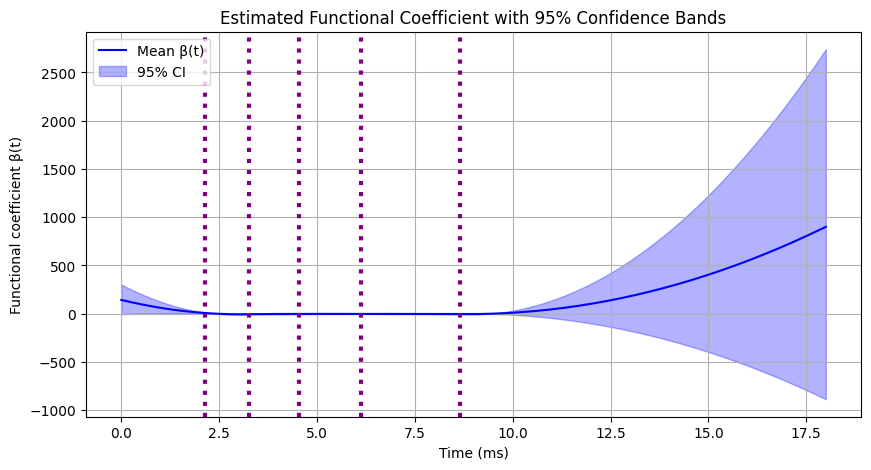

In [888]:
beta_array = np.vstack(beta_curves)  # shape: (n_bootstraps, n_timepoints)
mean_beta = np.mean(beta_array, axis=0)
lower_ci = np.percentile(beta_array, 2.5, axis=0)
upper_ci = np.percentile(beta_array, 97.5, axis=0)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(t, mean_beta, label='Mean β(t)', color='blue')
plt.fill_between(t, lower_ci, upper_ci, color='blue', alpha=0.3, label='95% CI')
for x in latency_marks:
    plt.axvline(x=x, linestyle=':', color='purple', linewidth=3)

plt.xlabel("Time (ms)")
plt.ylabel("Functional coefficient β(t)")
plt.title("Estimated Functional Coefficient with 95% Confidence Bands")
plt.legend()
plt.grid(True)
plt.show()


Points following wave V seem to have the highest significance? But I wouldn't code this in because ABRA did not detect a 6th peak.

Larger bands = greater variability in the bootstrapping

Above 0 = statistically significant [ONLY seen in 0-2.5 ms, Wave I]

Bootstrapping CIs here allows for localized interpretation and doesn't assume a Gaussian distribution.

OLS allows for global interpretation but it's not well tailored to a functional space.

In [853]:
# import statsmodels.api as sm

# X_ols = sm.add_constant(Xs)
# model = sm.OLS(y, X_ols).fit()
# print(model.summary())


In [852]:
# from skfda.representation.basis import BSplineBasis
# import matplotlib.pyplot as plt
# import numpy as np

# for n in range(3):
# # Assume you still have the basis used in your transformation
#     basis = bases[n]  # e.g. BSplineBasis(domain_range=(0,18), n_basis=7)
#     coeffs = Xs[n]

#     # Step 2: Evaluate basis functions at fine grid
#     t = np.linspace(*basis.domain_range[0], 200)
#     phi_t = basis.evaluate(t)[:, :, 0].T  # reshape to (200, n_basis)

#     # Step 3: Multiply basis by coefficients to reconstruct β(t)
#     # print("phi shape:", phi_t.shape, "coeffs:", coeffs.shape)
#     beta_t = phi_t @ coeffs
#     plt.plot(t, beta_t, label=f'Subject {n}')

#     # Step 4: Plot
# plt.xlabel("Time (ms)")
# plt.ylabel("β(t)")
# plt.title("Functional Coefficients β(t) Across Subjects")
# plt.grid(True)
# plt.legend()
# plt.show()


# 6. Adding strain as a predictor

In [913]:
np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx_encoded['Strain encoded (x5)'])

array([0, 1])

In [926]:
from skfda.misc.regularization import L2Regularization
from skfda.misc.operators import LinearDifferentialOperator

penalty = L2Regularization(linear_operator=LinearDifferentialOperator(2))
shared_grid = np.linspace(0, time_scale, 244)
# basis = BSplineBasis(n_basis=7, domain_range=(0,18)) # old
# smoother = BasisSmoother(basis=basis, return_basis=True) # , regularization=penalty, smoothing_parameter=0.1, 
time_scale = 18
subjects = []
frequencies = []
levels = []
raw_waves = []
newbasis_waves = []
Xs = []
ys = []
fails = []
strains = []

for (sub, freq), df in subject_ABRs.items():
    for lvl in np.unique(df['Level(dB)']):
        latencies_series = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx_encoded[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx_encoded['Subject'] == sub)\
            & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx_encoded['Freq(kHz) (x1)'] == freq)\
                & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx_encoded['Level(dB) (x2)'] == lvl)]\
            ['Latencies']
        
        if len(latencies_series) == 0:
            print(f'N/A latencies: ({sub}, {freq}, {lvl}) : {latencies_series}')
            continue

        latencies = latencies_series.values[0]
        latencies = [float(x) for x in latencies]
        # print(latencies)

        lvl = float(lvl)
        wave = full_interpolation(df, freq, lvl, time_scale)
        wave = np.asarray(wave, dtype=float)
        wave = wave.reshape(1, -1)

        encoded_strain_series = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx_encoded\
            [(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx_encoded['Subject'] == sub)]\
            ['Strain encoded (x5)']
        
        if len(encoded_strain_series) == 0:
            print(f'No strain found: ({sub}, {freq}, {lvl}) : {encoded_strain_series}')
            continue
        
        encoded_strain = encoded_strain_series.iloc[0]
        print(encoded_strain)
        strains.append(encoded_strain)

        grid = time_scale * np.arange(0, 244) / 244
        wave_input = skfda.FDataGrid(data_matrix=wave,grid_points=shared_grid)

        basis = BSplineBasis(domain_range=(latencies[0], latencies[-1]),knots = latencies, order = 3)
        smoother = BasisSmoother(basis=basis, return_basis=True)

        wave_newbasis = smoother.fit_transform(wave_input)[0] # smoother will allow regularization for further tuning down the line...

        X = wave_newbasis.coefficients

        y_series = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx_encoded[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx_encoded['Subject'] == sub)\
            & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx_encoded['Freq(kHz) (x1)'] == freq)\
            & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx_encoded['Level(dB) (x2)'] == lvl)]\
            ['Synapse to IHC Ratio per Freq (y2)']
        
        # print(y_series)

        if len(y_series) == 0 or pd.isna(y_series.iloc[0]):
            print(f'N/A y: ({sub}, {freq}, {lvl})')
            continue

        y = float(y_series.iloc[0])

        # print((sub, freq, lvl, y))
        subjects.append(sub)
        frequencies.append(freq)
        levels.append(lvl)
        raw_waves.append(wave_input)
        newbasis_waves.append(wave_newbasis)
        Xs.append(X.flatten()) # used for model fitting, same as for OLS!
        ys.append(y)

final_waves_df_new_basis_strained = pd.DataFrame(data = {'Subject' : subjects, 'Freq(kHz)' : frequencies, 'Level(dB)' : levels, 'Strain' : strains, 'Transformed Waves (X)' : Xs, 'Synapse to IHC Ratio per Freq (y2)' : ys})
final_waves_df_new_basis_strained_clean = final_waves_df_new_basis_strained.dropna().reset_index(drop=True)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1


In [927]:
X_nonfunc

,Freq(kHz),Level(dB),Strain
0,45.2,70.0,0
1,45.2,75.0,0
2,45.2,80.0,0
3,8.0,30.0,0
4,8.0,35.0,0
...,...,...,...
5947,32.0,40.0,0
5948,32.0,50.0,0
5949,32.0,60.0,0
5950,32.0,70.0,0


In [929]:
X = final_waves_df_new_basis_strained_clean['Transformed Waves (X)']
# X_relevant_waves = [x[:5] for x in X]
# X_func = np.vstack([x.flatten() for x in X_relevant_waves])
X_func = np.vstack([x.flatten() for x in X])
X_nonfunc = pd.DataFrame(final_waves_df_new_basis_strained_clean[['Freq(kHz)', 'Level(dB)', 'Strain']])

y = final_waves_df_new_basis_strained_clean['Synapse to IHC Ratio per Freq (y2)']

kf = GroupKFold(n_splits=5, shuffle=True, random_state=42)
best_alpha = None
best_score = np.inf

train_rmse, test_rmse = [], []  

for train_idx, test_idx in kf.split(X=X_func ,y=y,groups=final_waves_df_new_basis_strained_clean['Subject']):
    X_train_func, X_test_func = X_func[train_idx], X_func[test_idx]
    X_train_nonfunc, X_test_nonfunc = X_nonfunc.iloc[train_idx], X_nonfunc.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler()
    X_train_nonfunc_scaled = scaler.fit_transform(X_train_nonfunc)
    X_test_nonfunc_scaled = scaler.transform(X_test_nonfunc)

    model = LinearRegression()
    model.fit([X_train_func,X_train_nonfunc_scaled], y_train)

    y_train_hat = model.predict([X_train_func,X_train_nonfunc_scaled])
    y_test_hat = model.predict([X_test_func,X_test_nonfunc_scaled])

    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_hat)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_hat)))

avg_train_rmse = np.mean(train_rmse)
avg_test_rmse = np.mean(test_rmse)

train_rmse = np.array(train_rmse)
test_rmse = np.array(test_rmse)

train_rmse_se = np.std(train_rmse, ddof=1) / np.sqrt(len(train_rmse))
test_rmse_se = np.std(test_rmse, ddof=1) / np.sqrt(len(test_rmse))

print(f"Train RMSE: {avg_train_rmse:.4f} ± {train_rmse_se:.4f}")
print(f"Test RMSE:  {avg_test_rmse:.4f} ± {test_rmse_se:.4f}")

Train RMSE: 2.7570 ± 0.0405
Test RMSE:  2.8121 ± 0.1595
